# Import Packages

In [ ]:
# Standard Math and Data packages
import numpy as np
import pandas as pd

# Input data retrieval package
from google.colab import drive

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/gru
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set Random seed
import random
random.seed(42)

# Retrieve the Data


In [ ]:
drive.mount('/content/gdrive')
feeds = pd.read_csv('gdrive/My Drive/feeds.csv', index_col='created_at', parse_dates=['created_at'])
feeds.head()

Mounted at /content/gdrive


,device_id,feed_entry_id,luminosity_value,vibration_value,alert
created_at,,,,,
2024-11-26 20:51:07+00:00,1885576,499284,489,123,0
2024-11-26 20:51:27+00:00,1885576,499285,609,0,0
2024-11-26 20:51:39+00:00,1885576,499286,580,0,0
2024-11-26 20:51:46+00:00,1885576,499287,536,0,0
2024-11-26 20:52:03+00:00,1885576,499288,610,0,0


In [ ]:
feeds = feeds.drop(columns=['device_id', 'feed_entry_id'])
feeds.head()

,luminosity_value,vibration_value,alert
created_at,,,
2024-11-26 20:51:07+00:00,489,123,0
2024-11-26 20:51:27+00:00,609,0,0
2024-11-26 20:51:39+00:00,580,0,0
2024-11-26 20:51:46+00:00,536,0,0
2024-11-26 20:52:03+00:00,610,0,0


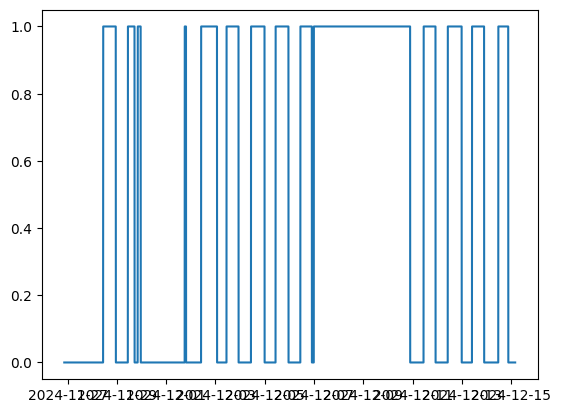

In [ ]:
plt.plot(feeds['alert'])

# Remove Invalid Entries

In [ ]:
feeds['luminosity_value'] = pd.to_numeric(feeds['luminosity_value'], errors='coerce')
feeds['vibration_value'] = pd.to_numeric(feeds['vibration_value'], errors='coerce')

feeds = feeds.dropna(subset=['luminosity_value'])
feeds.loc[:, 'vibration_value'] = feeds['vibration_value'].fillna(0)

feeds.head()

,luminosity_value,vibration_value,alert
created_at,,,
2024-11-26 20:51:07+00:00,489.0,123.0,0
2024-11-26 20:51:27+00:00,609.0,0.0,0
2024-11-26 20:51:39+00:00,580.0,0.0,0
2024-11-26 20:51:46+00:00,536.0,0.0,0
2024-11-26 20:52:03+00:00,610.0,0.0,0


# Convert Numbers to Percentages

In [ ]:
alerts = feeds['alert']

x = feeds.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

pct_change_feeds = pd.DataFrame(x_scaled)
pct_change_feeds.columns = feeds.columns

pct_change_feeds.head()

,luminosity_value,vibration_value,alert
0,0.788026,0.004176,0.0
1,0.982201,0.000000,0.0
2,0.935275,0.000000,0.0
3,0.864078,0.000000,0.0
4,0.983819,0.000000,0.0


# Univariate Forecasting (GRU)

created_at
2024-11-26 20:51:07+00:00    0
2024-11-26 20:51:27+00:00    0
2024-11-26 20:51:39+00:00    0
2024-11-26 20:51:46+00:00    0
2024-11-26 20:52:03+00:00    0
                            ..
2024-12-15 03:44:04+00:00    0
2024-12-15 03:44:23+00:00    0
2024-12-15 03:44:46+00:00    0
2024-12-15 03:45:11+00:00    0
2024-12-15 03:45:29+00:00    0
Name: alert, Length: 48394, dtype: int64


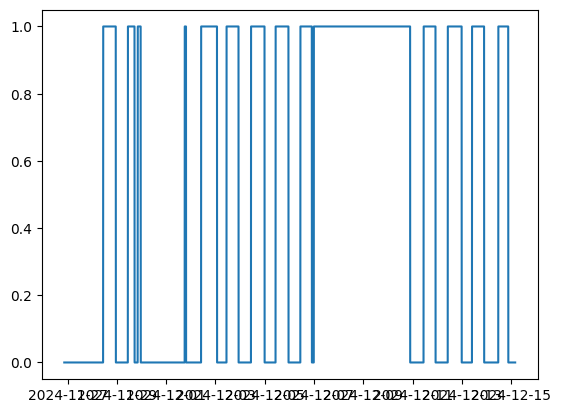

In [ ]:
print(alerts)
plt.plot(alerts)

In [ ]:
# Flatten this matrix down.
npa = alerts.values[1:].reshape(-1, 1) # Python is smart to recognize whatever dimension you need by using this parameter.
print(len(npa))

# Let's scale the data, this helps avoid the exploding gradient issue.
scale = MinMaxScaler(feature_range=(0, 1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

48393
48393


In [ ]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)].
samples = 10 # Number of samples (in past).
steps = 1 # Number of steps (in future).
X = []
Y = []
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples.
    Y.append(npa[i+samples][0]) # Dependent Samples.
print('Training data length is', len(X[0:1][0]), ':', X[0:1])
print('Testing data length is', len(Y[0:1]), ':', Y[0:1])

Training data length is 10 : [array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])]
Testing data length is 1 : [0.0]


In [ ]:
# Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (48383, 10, 1) Dimensions of Y (48383,)
Threshold is 43545


In [ ]:
# Build the GRU.
model = keras.Sequential()

# Add a GRU layer with 3 units.
model.add(layers.GRU(3,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models), prevents overfitting.
model.add(layers.Dropout(rate=0.2))

# Add a Dense layer with 1 units (because it's a regression task).
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 3)                   │              54 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58 (232.00 B)

 Trainable params: 58 (232.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the data.
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data.
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data.

Epoch 1/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0188 - val_loss: 0.0050
Epoch 2/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0136 - val_loss: 0.0040
Epoch 3/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0151 - val_loss: 0.0057
Epoch 4/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0153 - val_loss: 0.0019
Epoch 5/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0150 - val_loss: 0.0052
Epoch 6/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0155 - val_loss: 0.0026
Epoch 7/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0151 - val_loss: 0.0053
Epoch 8/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0153 - val_loss: 0.0048
Epoch 9/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0154 - val_loss: 0.0018
Epoch 10/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0148 - val_loss: 0.0045
Epoch 11/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0149 - val_loss: 0.0034
Epoch 12/100


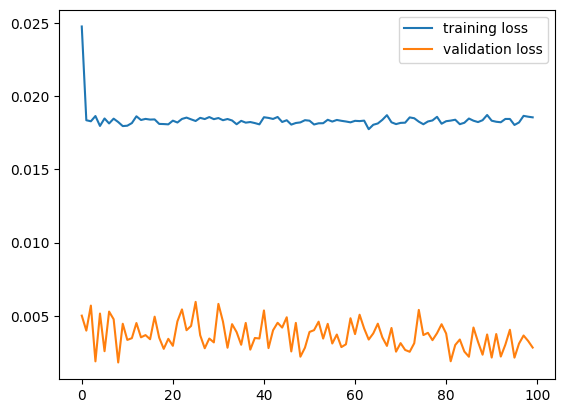

In [ ]:
# Plotting the loss iteration.
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting.
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset...).
# Several ways to address overfitting:
# - Reduce complexity of model (hidden layers, neurons, parameters input etc).
# - Add dropout and tune rate.
# - More data.

# Multi-Step Forecast

In [ ]:
# Predictions using the 'sliding/rolling window approach'.
# Multi step forecast.
# Using self predictions for making future predictions.
print(threshold)
true_Y = Y[threshold:]
pred_Y = []
print('Number of Forecasts to do: ', Y.shape[0] - round(Y.shape[0] * 0.9))
latest_input = X[threshold-1:threshold]

for i in range(Y.shape[0] - round(Y.shape[0] * 0.9)):
    # Prediction.
    p = model.predict(latest_input.reshape(1,X.shape[1],1))[0,0]

    # Update predictions.
    pred_Y.append(p)
    latest_input = np.append(X[threshold][1:], p)

43545
Number of Forecasts to do:  4838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

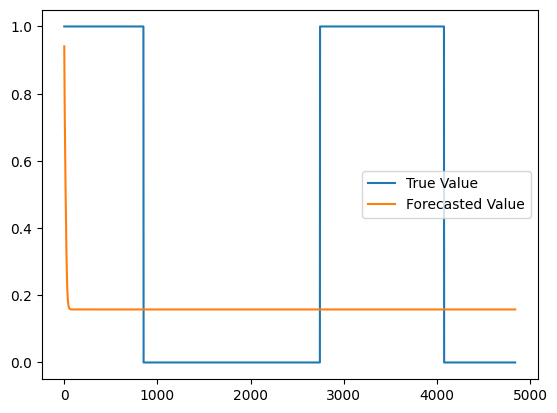

In [ ]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()

In [ ]:
pct_change_feeds

,luminosity_value,vibration_value,alert
0,0.788026,0.004176,0.0
1,0.982201,0.000000,0.0
2,0.935275,0.000000,0.0
3,0.864078,0.000000,0.0
4,0.983819,0.000000,0.0
...,...,...,...
48389,0.027508,0.000000,0.0
48390,0.027508,0.000000,0.0
48391,0.027508,0.000000,0.0
48392,0.027508,0.000000,0.0


from matplotlib import pyplot as plt
pct_change_feeds['luminosity_value'].plot(kind='hist', bins=20, title='luminosity_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pct_change_feeds['vibration_value'].plot(kind='hist', bins=20, title='vibration_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pct_change_feeds['alert'].plot(kind='hist', bins=20, title='alert')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pct_change_feeds.plot(kind='scatter', x='luminosity_value', y='vibration_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pct_change_feeds.plot(kind='scatter', x='vibration_value', y='alert', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pct_change_feeds['luminosity_value'].plot(kind='line', figsize=(8, 4), title='luminosity_value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pct_change_feeds['vibration_value'].plot(kind='line', figsize=(8, 4), title='vibration_value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pct_change_feeds['alert'].plot(kind='line', figsize=(8, 4), title='alert')
plt.gca().spines[['top', 'right']].set_visible(False)

# Multi-Variate Forecasting

In [ ]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)].
samples = 20 # Number of samples (in past).
steps = 1 # Number of steps (in future).
X = []
Y = []
for i in range(pct_change_feeds.shape[0] - samples):
    X.append(pct_change_feeds.iloc[i:i+samples, 0:2].values) # Independent Samples.
    Y.append(pct_change_feeds.iloc[i+samples, 2:].values) # Dependent Samples.
print('Training data length is', len(X[0:1][0]), ':', X[0:1])
print('Testing data length is', len(Y[0:1]), ':', Y[0:1])

Training data length is 20 : [array([[0.78802589, 0.00417615],
       [0.98220065, 0.        ],
       [0.93527508, 0.        ],
       [0.86407767, 0.        ],
       [0.98381877, 0.        ],
       [0.9579288 , 0.00546634],
       [0.9789644 , 0.00179948],
       [0.98867314, 0.        ],
       [0.98867314, 0.        ],
       [0.99190939, 0.        ],
       [0.9789644 , 0.        ],
       [0.96278317, 0.        ],
       [1.        , 0.        ],
       [0.97087379, 0.        ],
       [0.97734628, 0.        ],
       [0.98867314, 0.        ],
       [0.97734628, 0.        ],
       [0.80097087, 0.        ],
       [0.76213592, 0.        ],
       [0.78964401, 0.        ]])]
Testing data length is 1 : [array([0.])]


In [ ]:
# Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (48374, 20, 2) Dimensions of Y (48374, 1)


In [ ]:
# Get the training and testing set.
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training length', trainX.shape, trainY.shape, 'Testing length:', testX.shape, testY.shape)

Training length (43537, 20, 2) (43537, 1) Testing length: (4837, 20, 2) (4837, 1)


In [ ]:
# Build the GRU.
model = keras.Sequential()

# Add a GRU layer with 15 units.
model.add(layers.GRU(15,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models), prevents overfitting.
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (because we are doing a regression task).
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='binary_crossentropy', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                         │ (None, 15)                  │             855 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 871 (3.40 KB)

 Trainable params: 871 (3.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the data.
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data.
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data.

Epoch 1/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 2.3503 - val_loss: 0.5142
Epoch 2/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.8426 - val_loss: 0.3897
Epoch 3/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.1851 - val_loss: 0.3763
Epoch 4/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.2447 - val_loss: 0.2870
Epoch 5/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.7549 - val_loss: 0.2708
Epoch 6/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.9216 - val_loss: 0.2841
Epoch 7/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.6728 - val_loss: 0.2752
Epoch 8/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.8272 - val_loss: 0.2789
Epoch 9/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.2662 - val_loss: 1.7602
Epoch 10/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.5794 - val_loss: 0.7418
Epoch 11/100
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.5612 - val_loss: 0.30

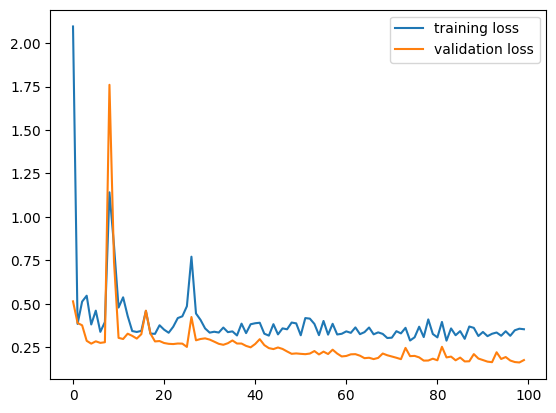

In [ ]:
# Plotting the loss iteration.
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting.
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset...).
# Several ways to address overfitting:
# - Reduce complexity of model (hidden layers, neurons, parameters input etc).
# - Add dropout and tune rate.
# - More data.

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


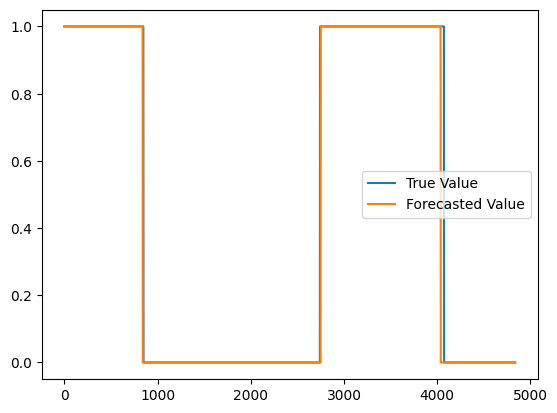

In [ ]:
# This is a one step forecast (based on how the model was constructed).
y_pred = model.predict(testX)
y_pred = (y_pred > 0.3).astype(int) # Classifier.
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

# Save the Model

In [ ]:
model.save('/content/gdrive/MyDrive/tcc3_2.h5')

.

.

.

.